## skip to START HERE line if import has been done

### From database of companies, import all 66/67 companies for testing purposes

In [2]:
#load data from mongodb's collection of tweets_by_companies into pandas. Run mongod to start mongodb
import pandas as pd
import pymongo
from pymongo import MongoClient
mc = MongoClient()
db = mc.twitter_db
input_data = db.tweets_by_companies
data = pd.DataFrame(list(input_data.find()))


In [170]:
data['company'] = data['user'].apply(lambda x: x['name'])

In [252]:
# exclude replies which are usually apologies to concerned customers
tweet_data = data[data['in_reply_to_screen_name'].isnull() == True]

In [259]:
tweet_data['company'].value_counts()

eBay                   5336
ToysRUs                4719
Netflix US             3959
App Store              3567
Disney                 3326
Barnes & Noble         3170
Guitar Center          3033
iTunes                 3026
Coach, Inc.            2974
Forever 21             2870
Amazon                 2708
Aeria Games            2557
Tiffany & Co.          2368
BabiesRUs              2292
Urban Outfitters       2245
AERO                   2234
Cinemark Theatres      2107
H&M                    2089
The Home Depot         2063
IKEA USA               2018
Williams-Sonoma        1911
Best Buy               1883
Pier 1 Imports         1610
Hotels.com             1609
Ann Taylor             1568
Ace Hardware           1516
T.J.Maxx               1467
PetSmart               1424
Fandango               1422
QVC                    1421
                       ... 
CVS/pharmacy            331
Whole Foods Market      310
Sears                   304
Cabela's                292
Kohl's              

### filter data to only show company name and tweet. Also drop any duplicate tweets

In [260]:
important_columns = ['company', 'text']
company_tweets = tweet_data.loc[: , important_columns]
company_tweets = company_tweets.drop_duplicates()
company_tweets['company'].value_counts()

Disney                 3324
App Store              3247
Barnes & Noble         3168
Guitar Center          3024
iTunes                 3024
Coach, Inc.            2955
Forever 21             2870
Amazon                 2696
eBay                   2666
Aeria Games            2534
Netflix US             2457
ToysRUs                2369
Tiffany & Co.          2359
BabiesRUs              2282
Urban Outfitters       2245
AERO                   2234
Cinemark Theatres      2107
The Home Depot         2053
IKEA USA               2017
Williams-Sonoma        1900
Best Buy               1882
H&M                    1677
Pier 1 Imports         1609
Hotels.com             1602
Ann Taylor             1552
Ace Hardware           1490
T.J.Maxx               1454
Fandango               1417
PetSmart               1416
QVC                    1408
                       ... 
CVS/pharmacy            331
Whole Foods Market      310
Sears                   304
Cabela's                292
Kohl's              

In [177]:
import cPickle as pickle
with open('../data/company_tweets.pkl', 'w') as f:
    pickle.dump(company_tweets, f)

## Cleaning tweets of companies ------------------------------------------------------------------------- 

In [178]:
import pandas as pd
import cPickle as pickle
company_tweets = pd.read_pickle('../data/company_tweets.pkl')

In [179]:
company_tweets['company'].value_counts()

Disney                 3325
App Store              3249
Barnes & Noble         3175
Guitar Center          3025
iTunes                 3024
Coach, Inc.            2971
Forever 21             2875
The Home Depot         2781
Amazon                 2708
eBay                   2671
Netflix US             2547
Aeria Games            2546
ToysRUs                2408
Tiffany & Co.          2360
Urban Outfitters       2296
BabiesRUs              2288
AERO                   2249
Cinemark Theatres      2187
IKEA USA               2043
Williams-Sonoma        1986
Best Buy               1897
H&M                    1692
Pier 1 Imports         1653
Hotels.com             1612
Ace Hardware           1583
Ann Taylor             1561
T.J.Maxx               1519
Zappos                 1450
Cheesecake Factory     1444
Fandango               1434
                       ... 
Walgreens               478
Victoria's Secret       465
Sears                   426
Whole Foods Market      408
Bath & Body Works   

# START HERE ------------------------------------------------------

In [2]:
import pandas as pd
import cPickle as pickle
company_tweets = pd.read_pickle('../data/clean_companies.pkl')

### Remove all bit.ly and @ tags from stores' tweets

In [3]:
import re

def remove_links_and_tags(words):
    if 'http' in words or '@' in words:
        return re.sub('(RT)|(RT @[_A-Za-z0-9]+)|(@[_A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)', '', words)
    return words 

# after stemming
def remove_irrelevant_terms(words):
    return re.sub('\\bsorri\\b|\\bpleas\\b|\\bthank\\b|\\nthx\\b|\\bhi\\b|\\bfave\\b|\\bdm\\b|\\bamp\\b|\\bnew\\b|\\bshop\\|', '', words)

def remove_links(words):
    if 'http' in words:
        return re.sub('([^0-9A-Za-z \t])|(\w+:\/\/\S+)', '', words)
    return words 

### Stemming each tweet

In [4]:
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

snowball = SnowballStemmer('english')

### Python 2 unicode values, translate() only takes a dictionary

In [5]:
translation_table = dict.fromkeys(map(ord, ')(][:.",!#&;$?'), None)
company_tweets['stemmed_text'] = company_tweets['simple_text'].apply(lambda sent: ' '.join([snowball.stem(word) for \
                                    word in sent.translate(translation_table).split()]))

In [6]:
company_tweets['stripped_text'] = company_tweets['stemmed_text'].apply(lambda x: remove_irrelevant_terms(x))

In [7]:
company_tweets['company'].value_counts()

Disney                 3325
App Store              3249
Barnes & Noble         3175
Guitar Center          3025
iTunes                 3024
Coach, Inc.            2971
Forever 21             2875
The Home Depot         2781
Amazon                 2708
eBay                   2671
Netflix US             2547
Aeria Games            2546
ToysRUs                2408
Tiffany & Co.          2360
Urban Outfitters       2296
BabiesRUs              2288
AERO                   2249
Cinemark Theatres      2187
IKEA USA               2043
Williams-Sonoma        1986
Best Buy               1897
H&M                    1692
Pier 1 Imports         1653
Hotels.com             1612
Ace Hardware           1583
Ann Taylor             1561
T.J.Maxx               1519
Zappos                 1450
Cheesecake Factory     1444
Fandango               1434
                       ... 
Walgreens               478
Victoria's Secret       465
Sears                   426
Whole Foods Market      408
Bath & Body Works   

### Import sklearn's TfidfVectorizer and create a vector for each company

In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import defaultdict

In [15]:
company_list = company_tweets['company'].value_counts().index

### Trying out OneVsRestClassifier

In [8]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC, SVC # using LinearSVC since it works well with a large number of features
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

In [9]:
# OvRLSVC
X = company_tweets['stripped_text']
y = company_tweets['company']
tfid_vectorizer = TfidfVectorizer(stop_words='english')
tf = tfid_vectorizer.fit_transform(X)
OvR = OneVsRestClassifier(LinearSVC(random_state=0))
OvR.fit(tf, y)

OneVsRestClassifier(estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0),
          n_jobs=1)

### Take a shard of users and their tweets 

In [10]:
import pymongo
from pymongo import MongoClient
mc = MongoClient()
db = mc.twitter_db

input_data = db.tweets_by_users
users = pd.DataFrame(list(input_data.find().limit(30000)))

In [35]:
users['user_name'] = users['user'].apply(lambda x: x['screen_name'].encode('ascii'))

In [ ]:
users['user_name'].value_counts()

In [36]:
important_columns = ['user_name', 'text']
user_df = users.loc[: , important_columns]

In [39]:
user_df['simple_text'] = user_df['text'].apply(lambda x: remove_links(x)) 

In [35]:
user_df

,user_name,text,simple_text
0,chunkypots,@Cheesecake for dinner 💯 https://t.co/Ce3hzP8F0s,Cheesecake for dinner
1,chunkypots,@thetenspot awesome!!!,@thetenspot awesome!!!
2,chunkypots,@stajans_girl @pkumaaar_ LMAO YESSSSS,@stajans_girl @pkumaaar_ LMAO YESSSSS
3,chunkypots,💖 https://t.co/cOLa2JYvUC,
4,chunkypots,@stajans_girl I bought Pooj chocolate dipped O...,@stajans_girl I bought Pooj chocolate dipped O...
5,chunkypots,@stajans_girl YO I need to see you soon! Just ...,@stajans_girl YO I need to see you soon! Just ...
6,chunkypots,Mulberry Cafe has the cutest tree!! https://t....,Mulberry Cafe has the cutest tree
7,chunkypots,Any bobs burger reference makes the fam strong...,Any bobs burger reference makes the fam strong...
8,chunkypots,@stajans_girl I want to knit just so I can say...,@stajans_girl I want to knit just so I can say...
9,chunkypots,@thetenspot what's the name of the quick dry s...,@thetenspot what's the name of the quick dry s...


### Analyze sentiment for each tweet

#### nltk.sentiment.vader is used because it takes into consideration special case idioms, capitalization, punctuation, and deals specifically with social media texts

VADER (Valence Aware Dictionary and sEntiment Reasoner) 

source code: http://www.nltk.org/_modules/nltk/sentiment/vader.html

Github: https://github.com/cjhutto/vaderSentiment

VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text 
(by C.J. Hutto and Eric Gilbert) 
Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.  http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf

In [40]:
from nltk.sentiment.sentiment_analyzer import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [41]:
sid = SentimentIntensityAnalyzer()
user_df['sentiment'] = user_df['text'].apply(lambda x: sid.polarity_scores(x))

In [46]:
user_df['sentiment'].values[0]

0        {u'neg': 0.0, u'neu': 1.0, u'pos': 0.0, u'comp...
1        {u'neg': 0.0, u'neu': 0.167, u'pos': 0.833, u'...
2        {u'neg': 0.0, u'neu': 0.393, u'pos': 0.607, u'...
3        {u'neg': 0.0, u'neu': 1.0, u'pos': 0.0, u'comp...
4        {u'neg': 0.0, u'neu': 1.0, u'pos': 0.0, u'comp...
5        {u'neg': 0.0, u'neu': 1.0, u'pos': 0.0, u'comp...
6        {u'neg': 0.0, u'neu': 0.578, u'pos': 0.422, u'...
7        {u'neg': 0.0, u'neu': 0.755, u'pos': 0.245, u'...
8        {u'neg': 0.0, u'neu': 0.92, u'pos': 0.08, u'co...
9        {u'neg': 0.0, u'neu': 1.0, u'pos': 0.0, u'comp...
10       {u'neg': 0.0, u'neu': 1.0, u'pos': 0.0, u'comp...
11       {u'neg': 0.0, u'neu': 0.602, u'pos': 0.398, u'...
12       {u'neg': 0.0, u'neu': 0.74, u'pos': 0.26, u'co...
13       {u'neg': 0.0, u'neu': 0.93, u'pos': 0.07, u'co...
14       {u'neg': 0.0, u'neu': 0.828, u'pos': 0.172, u'...
15       {u'neg': 0.0, u'neu': 1.0, u'pos': 0.0, u'comp...
16       {u'neg': 0.0, u'neu': 1.0, u'pos': 0.0, u'comp.

#### Keeping only tweets classified as positive

In [42]:
pos_user_tweets = user_df[user_df['sentiment'].apply(lambda x: x['pos']) > .45]

In [65]:
pd.util.terminal.get_terminal_size()

(113, 21)

In [69]:
pd.set_option('display.max_colwidth', 250)

In [71]:
pos_user_tweets

,user_name,text,simple_text,sentiment,stemmed_text
1,chunkypots,@thetenspot awesome!!!,@thetenspot awesome!!!,"{u'neg': 0.0, u'neu': 0.167, u'pos': 0.833, u'compound': 0.7163}",@thetenspot awesom
2,chunkypots,@stajans_girl @pkumaaar_ LMAO YESSSSS,@stajans_girl @pkumaaar_ LMAO YESSSSS,"{u'neg': 0.0, u'neu': 0.393, u'pos': 0.607, u'compound': 0.6841}",@stajans_girl @pkumaaar_ lmao yesssss
20,chunkypots,Always the BEST service and amazing manicure at @thetenspot !! Thanks for a lovely start to my morning!! https://t.co/fFCDfP15ot,Always the BEST service and amazing manicure at thetenspot Thanks for a lovely start to my morning,"{u'neg': 0.0, u'neu': 0.458, u'pos': 0.542, u'compound': 0.9559}",alway the best servic and amaz manicur at thetenspot thank for a love start to my morn
28,chunkypots,@rohinghai friendship over.,@rohinghai friendship over.,"{u'neg': 0.0, u'neu': 0.408, u'pos': 0.592, u'compound': 0.4404}",@rohinghai friendship over
41,chunkypots,@JovanHeer lol!! Haha okay that's fair,@JovanHeer lol!! Haha okay that's fair,"{u'neg': 0.0, u'neu': 0.159, u'pos': 0.841, u'compound': 0.8619}",@jovanh lol haha okay that fair
50,chunkypots,@rohinghai LMAO oh god,@rohinghai LMAO oh god,"{u'neg': 0.0, u'neu': 0.229, u'pos': 0.771, u'compound': 0.7739}",@rohinghai lmao oh god
51,chunkypots,@rohinghai LMAO how did you just have that on hand,@rohinghai LMAO how did you just have that on hand,"{u'neg': 0.0, u'neu': 0.505, u'pos': 0.495, u'compound': 0.8331}",@rohinghai lmao how did you just have that on hand
53,chunkypots,@rohinghai you'll need fair n lovely,@rohinghai you'll need fair n lovely,"{u'neg': 0.0, u'neu': 0.33, u'pos': 0.67, u'compound': 0.7269}",@rohinghai you'll need fair n love
73,chunkypots,Drinks n burgers after work with my best friend is the perfect pre holiday meet up💯,Drinks n burgers after work with my best friend is the perfect pre holiday meet up💯,"{u'neg': 0.0, u'neu': 0.444, u'pos': 0.556, u'compound': 0.93}",drink n burger after work with my best friend is the perfect pre holiday meet up💯
90,chunkypots,@rohinghai lmao I clicked reply,@rohinghai lmao I clicked reply,"{u'neg': 0.0, u'neu': 0.435, u'pos': 0.565, u'compound': 0.5994}",@rohinghai lmao i click repli


In [41]:
pos_user_tweets['user_name'].value_counts()

_justolentino     324
RaffyEloy         303
nakiyarussell     241
emiiistyles       218
kylee_elaine_     186
quiwop            171
chunkypots        160
MojoRawleyWWE     151
elena_guy         149
Itss_angel_cx     141
trippnationn      141
MissDTaylor_      134
lovecoutureee_    132
USUAggie1990      114
ChristinaAAAHD    102
ohozaru           102
yungjosey          99
MaddenDC           93
matt_brownlee8     78
YZAKALLO           77
chuck_haze         72
__Ganjaaa          56
zjmftzolo          19
JULIANAMEGGERS      6
RadtkeKristin       2
swnseanews          2
Name: user_name, dtype: int64

#### Keeping only tweets classified as non negative

In [16]:
nneg_user_tweets = user_df[user_df['sentiment'].apply(lambda x: x['neg']) < .49]

In [43]:
nneg_user_tweets['user_name'].value_counts()

zjmftzolo         3232
MojoRawleyWWE     3226
swnseanews        3224
MaddenDC          3209
emiiistyles       3203
ChristinaAAAHD    3189
USUAggie1990      3187
chunkypots        3153
chuck_haze        3151
nakiyarussell     3127
__Ganjaaa         3117
lovecoutureee_    3115
_justolentino     3100
MissDTaylor_      3094
quiwop            3081
matt_brownlee8    3063
Itss_angel_cx     3050
elena_guy         3023
RaffyEloy         2996
YZAKALLO          2984
trippnationn      2907
ohozaru           2773
kylee_elaine_     2734
yungjosey         2242
JULIANAMEGGERS     196
RadtkeKristin      100
royray0              1
Name: user_name, dtype: int64

### Time to stem each tweet using snowball

In [60]:
pos_user_tweets['stemmed_text'] = pos_user_tweets['simple_text'].apply(lambda sent: ' '.join([snowball.stem(word) for \
                                    word in sent.translate(translation_table).split()]))
# nneg_user_tweets['stemmed_text'] = nneg_user_tweets['simple_text'].apply(lambda sent: ' '.join([snowball.stem(word) \
#                                    for word in sent.translate(translation_table).split()]))

/Users/Kimyen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [63]:
pos_user_tweets.iloc[2:3]

,user_name,text,simple_text,sentiment,stemmed_text
20,chunkypots,Always the BEST service and amazing manicure a...,Always the BEST service and amazing manicure a...,"{u'neg': 0.0, u'neu': 0.458, u'pos': 0.542, u'...",alway the best servic and amaz manicur at thet...


### Create a list of users

In [14]:
user_list = pos_user_tweets['user_name'].value_counts().index
user_list

Index([u'chunkypots', u'quiwop', u'trippnationn', u'lovecoutureee_',
       u'USUAggie1990', u'yungjosey', u'matt_brownlee8', u'chuck_haze',
       u'ChristinaAAAHD', u'__Ganjaaa', u'RadtkeKristin'],
      dtype='object')

In [ ]:
# user_vects = defaultdict(list)
# for user in user_list:
#     documents = pos_user_tweets[pos_user_tweets['user_name'] == user].stemmed_text
#     vect_name = 'tfidf_'+user
#     #print documents.values[0]
#     user_vects[vect_name] = tfidf.fit_transform(documents)

In [15]:
user_docs = []
for user in user_list:
    a = ' '.join([text for text in pos_user_tweets[pos_user_tweets['user_name']==user].stemmed_text.values])
    user_docs.append(a)

### Multinomial Naive Bayes

In [24]:
from sklearn.naive_bayes import MultinomialNB

In [31]:
user_docs_pos = []
for user in user_list:
    a = ' '.join([text for text in pos_user_tweets[pos_user_tweets['user_name']== user].text.values])
    user_docs_pos.append(a)

In [26]:
user_docs_nneg = []
for user in user_list:
    a = ' '.join([text for text in nneg_user_tweets[nneg_user_tweets['user_name']== user].text.values])
    user_docs_nneg.append(a)

In [62]:
company_tweets[company_tweets['company'] == 'Staples'].stemmed_text.values[:4]

array([u'we still love ya lol hn',
       u'2015 s resolut take the stair 2016 s newyear resolut actual take the stair what s your',
       u'be cool you got this officepartyetiquett morethisholiday',
       u'thank you i will send this feedback to our copi print team to look into websit upgrad al'], dtype=object)

In [72]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [28]:
X = company_tweets['stripped_text']
y = company_tweets['company']
count_vectorizer = CountVectorizer(stop_words='english')
tf = count_vectorizer.fit_transform(X)
clf = MultinomialNB()
clf.fit(tf, y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [193]:
for user in user_docs_pos:
    X1 = count_vectorizer.transform([user])
    pred = clf.predict(X1)
    print pred[0]

Fandango
Barnes & Noble
Amazon
Hotels.com
Hotels.com
Barnes & Noble
BabiesRUs
Barnes & Noble
Barnes & Noble
Barnes & Noble
Barnes & Noble
Barnes & Noble
Barnes & Noble
Barnes & Noble
Barnes & Noble
Barnes & Noble
Barnes & Noble
Barnes & Noble
Barnes & Noble
Barnes & Noble
Barnes & Noble
Disney
Barnes & Noble
Barnes & Noble
ToysRUs
Barnes & Noble
Disney


### Use Cosine Similarity to compare documents of user tweets to company tweets

This kernel is a popular choice for computing the similarity of documents represented as tf-idf vectors. cosine_similarity accepts scipy.sparse matrices. (Note that the tf-idf functionality in sklearn.feature_extraction.text can produce normalized vectors, in which case cosine_similarity is equivalent to linear_kernel, only slower.)

In [70]:
from sklearn.metrics.pairwise import linear_kernel 
import numpy as np

In [202]:
# With positive tweets only

from copy import copy

vect = TfidfVectorizer(stop_words='english')
i = 1
for user_tweets in user_docs_pos:
    all_docs = copy(com_docs)
    all_docs.append(user_tweets)

    X = vect.fit_transform(all_docs)
    M = linear_kernel(X, X)
    sortedM = np.argsort(M[-1])[::-1][1:3]
    a, b = company_list[sortedM]
    numA, numB = M[-1][sortedM]
    print "{}) Top matches: {} ({}%) and {} ({}%)".format(i, a, round(numA * 100, 2), b, round(numB * 100, 2))
    i += 1

1) Top matches: Fandango (8.94%) and BabiesRUs (6.58%)
2) Top matches: Disney (10.39%) and ToysRUs (9.44%)
3) Top matches: Fandango (3.83%) and BabiesRUs (2.22%)
4) Top matches: Fandango (7.3%) and BabiesRUs (5.74%)
5) Top matches: Fandango (8.64%) and BabiesRUs (6.95%)
6) Top matches: Disney (12.47%) and Fandango (11.14%)
7) Top matches: Fandango (13.64%) and BabiesRUs (12.95%)
8) Top matches: Disney (7.74%) and Target (5.93%)
9) Top matches: Disney (5.93%) and ToysRUs (5.68%)
10) Top matches: Disney (10.14%) and Fandango (9.37%)
11) Top matches: Fandango (5.27%) and Ticketmaster (4.43%)
12) Top matches: Disney (10.41%) and Fandango (10.05%)
13) Top matches: ToysRUs (4.13%) and Disney (3.62%)
14) Top matches: Disney (6.65%) and Fandango (6.53%)
15) Top matches: Disney (8.37%) and Fandango (8.26%)
16) Top matches: ToysRUs (8.71%) and Fandango (7.04%)
17) Top matches: Disney (5.39%) and Fandango (4.88%)
18) Top matches: Fandango (8.37%) and Disney (8.12%)
19) Top matches: Disney (2.14%)

In [203]:
# With nonnegative tweets

from copy import copy

vect = TfidfVectorizer(stop_words='english')
i = 1
for user_tweets in user_docs_nneg:
    all_docs = copy(com_docs)
    all_docs.append(user_tweets)

    X = vect.fit_transform(all_docs)
    M = linear_kernel(X, X)
    sortedM = np.argsort(M[-1])[::-1][1:3]
    a, b = company_list[sortedM]
    numA, numB = M[-1][sortedM]
    print "{}) Top matches: {} ({}%) and {} ({}%)".format(i, a, round(numA * 100, 2), b, round(numB*100, 2))
    i += 1

1) Top matches: Fandango (3.71%) and iTunes (2.94%)
2) Top matches: Disney (8.7%) and ToysRUs (8.06%)
3) Top matches: Ticketmaster (2.21%) and Fandango (1.62%)
4) Top matches: ToysRUs (4.78%) and Fandango (4.75%)
5) Top matches: Fandango (4.95%) and ToysRUs (4.01%)
6) Top matches: QVC (13.12%) and Disney (8.04%)
7) Top matches: ToysRUs (9.35%) and Disney (8.69%)
8) Top matches: Disney (11.28%) and Target (9.31%)
9) Top matches: Disney (6.67%) and ToysRUs (5.71%)
10) Top matches: Disney (7.56%) and ToysRUs (6.36%)
11) Top matches: Ticketmaster (4.0%) and Fandango (3.59%)
12) Top matches: QVC (6.75%) and Disney (5.3%)
13) Top matches: QVC (5.36%) and ToysRUs (4.27%)
14) Top matches: Disney (5.76%) and ToysRUs (4.92%)
15) Top matches: Disney (8.66%) and ToysRUs (7.98%)
16) Top matches: ToysRUs (5.23%) and Fandango (4.94%)
17) Top matches: Disney (4.48%) and Fandango (4.28%)
18) Top matches: Disney (6.0%) and ToysRUs (5.19%)
19) Top matches: Disney (2.48%) and ToysRUs (2.17%)
20) Top match

In [ ]:
# cosine similartity between stores & 1 user
# test_doc = copy(com_docs)
# test_doc.append(user_docs[0])

# vect = TfidfVectorizer(stop_words='english')
# X = vect.fit_transform(test_doc)
# M = linear_kernel(X, X)
# sortedM = np.argsort(M[-1])[::-1][1:3]
# a, b = company_list[sortedM]
# print a, b
# print M[-1]

In [ ]:
# top features

indices = np.argsort(vect.idf_)[::-1]
features= vect.get_feature_names()
top_n = 20
top_features = [features[i] for i in indices[:top_n]]
print top_features

In [ ]:
company_list[sortedM2]

In [ ]:
sortedM2 = np.argsort(M[-1])[::-1][1:3]

In [32]:
user0 = tfid_vectorizer.transform([user_docs_pos[0]])
pred = OvR.predict(user0)
df = OvR.decision_function(user0)
# print "{}: {}".format(i, pred[0])
pred

array([u'Hotels.com'], 
      dtype='<U19')

In [68]:
companies = OvR.classes_

In [79]:
companies[np.argsort(df)[0][::-1][0:3]]

array([u'Hotels.com', u'Barnes & Noble', u'Zappos'], 
      dtype='<U19')

In [62]:
df

array([[-1.91236045, -1.69236838, -1.70324752, -1.22056527, -1.10893276,
        -2.04552769, -0.92239225, -1.76073373, -0.69104405, -1.33047313,
        -1.16456484, -1.59291343, -1.58026244, -1.14471839, -0.97095865,
        -1.37220325, -1.45695634, -0.89899168, -1.82864799, -1.58289482,
        -1.43409928, -1.77392148, -1.15035032, -1.53618641, -1.93746412,
        -1.23444669, -1.35417421, -1.46922893, -0.68539286, -1.30501544,
        -1.23088967, -1.00431429, -1.29969265, -1.33192665, -1.14634792,
        -1.71199287, -1.07041908, -1.05822053, -1.80350142, -1.25451295,
        -1.4392529 , -1.34353999, -1.32354668, -1.1805223 , -1.69891406,
        -1.65526123, -1.40678715, -1.01937764, -1.36798077, -0.98912779,
        -1.40977363, -1.25525028, -1.76987822, -1.21681909, -1.14512274,
        -1.52139902, -1.21238748, -1.13289188, -1.17890992, -1.13742383,
        -1.67895912, -1.69669227, -1.44241939, -0.84484877, -1.13218608,
        -1.4225936 , -1.37276201, -1.1553383 , -1.3

In [58]:
stores = df.argmax()
company_list[stores]

u'Cheesecake Factory'

In [52]:
stores[0]

28

In [64]:
company_list

Index([u'Disney', u'App Store', u'Barnes & Noble', u'Guitar Center', u'iTunes',
       u'Coach, Inc.', u'Forever 21', u'The Home Depot', u'Amazon', u'eBay',
       u'Netflix US', u'Aeria Games', u'ToysRUs', u'Tiffany & Co.',
       u'Urban Outfitters', u'BabiesRUs', u'AERO', u'Cinemark Theatres',
       u'IKEA USA', u'Williams-Sonoma', u'Best Buy', u'H&M', u'Pier 1 Imports',
       u'Hotels.com', u'Ace Hardware', u'Ann Taylor', u'T.J.Maxx', u'Zappos',
       u'Cheesecake Factory', u'Fandango', u'Sports Authority', u'PetSmart',
       u'QVC', u'Etsy', u'The Container Store', u'Gap', u'Ticketmaster',
       u'Banana Republic', u'Red Lobster', u'LEGO', u'JCPenney',
       u'Michaels Stores', u'Old Navy Official', u'CVS/pharmacy',
       u'Bed Bath & Beyond', u'Walgreens', u'Victoria's Secret', u'Sears',
       u'Whole Foods Market', u'Bath & Body Works', u'Cabela's', u'Sephora',
       u'Kohl's', u'Staples US', u'GameStop', u'Ulta Beauty', u'Macy's',
       u'Dunkin' Donuts', u'IHOP', u'L

In [82]:
user_list[10]

'RadtkeKristin'

In [80]:
# for positive tweets

i = 1
for user in user_docs_pos:
    X1 = tfid_vectorizer.transform([user])
    preds = OvR.decision_function(X1)
    companies = OvR.classes_
    lst = companies[np.argsort(preds)[0][::-1][0:3]]
    print "{}: {}, {}, {}".format(i, lst[0],lst[1], lst[2] )
    i += 1

1: Hotels.com, Barnes & Noble, Zappos
2: Barnes & Noble, Zappos, Cinemark Theatres
3: Hotels.com, Barnes & Noble, Tiffany & Co.
4: Hotels.com, Netflix US, QVC
5: Hotels.com, Sports Authority, ToysRUs
6: Hotels.com, Barnes & Noble, Sears
7: Hotels.com, ToysRUs, Barnes & Noble
8: Hotels.com, Barnes & Noble, Bed Bath & Beyond
9: Hotels.com, Tiffany & Co., Guitar Center
10: Hotels.com, Ticketmaster, Urban Outfitters
11: Cheesecake Factory, Tiffany & Co., iTunes


In [239]:
# for nonnegative tweets

i = 1
for user in user_docs_nneg:
    X1 = tfid_vectorizer.transform([user])
    pred = OvR.predict(X1)
    print "{}: {}".format(i, pred[0])
    i += 1

1: H&M
2: Hotels.com
3: Ticketmaster
4: Hotels.com
5: Hotels.com
6: Hotels.com
7: Hotels.com
8: Hotels.com
9: Hotels.com
10: Hotels.com
11: Hotels.com
12: Hotels.com
13: Barnes & Noble
14: Hotels.com
15: Hotels.com
16: Hotels.com
17: Hotels.com
18: Hotels.com
19: Barnes & Noble
20: Hotels.com
21: Hotels.com
22: Hotels.com
23: Hotels.com
24: Hotels.com
25: Hotels.com
26: Ticketmaster
27: Coach, Inc.


In [100]:
user = "bath body hey person lego disney dumbo star"
X1 = tfid_vectorizer.transform([user])
pred = OvR.predict(X1)
df = OvR.decision_function(X1)

In [102]:
df

array([[-1.62703371, -2.1442574 , -1.99161163, -1.75540408, -2.10805134,
        -1.92685488, -1.52084161, -1.50019225, -1.48109437, -1.36144669,
        -0.91954313, -1.70298409, -1.60012791, -1.48098883, -2.01678671,
        -1.15360607, -1.2160721 , -1.95724118, -2.098039  ,  1.15426023,
        -1.51235812, -1.65051181, -1.72083115, -1.98613724, -1.19671004,
        -1.8615198 , -2.00413989, -1.35006003, -1.77547355, -1.34984323,
        -2.17018738, -1.48482438, -1.46578518, -0.07673893, -0.73522937,
        -1.1926712 , -1.24150244, -1.57084716, -1.80349761, -1.341505  ,
        -1.26248656, -1.3983984 , -1.77894179, -1.17070843, -1.22913184,
        -2.21505456, -1.19589876, -1.40818867, -1.37312828, -1.69700221,
        -1.3605338 , -1.36235658, -1.81175498, -1.83528011, -1.64527184,
        -1.3854892 , -1.54634399, -1.08864804, -1.19929504, -1.48430337,
        -1.40833678, -1.15020758, -1.7456364 , -1.00216767, -1.48910097,
        -1.98131476, -1.47519575, -1.65577258, -1.2

In [103]:
company_list

Index([u'Disney', u'App Store', u'Barnes & Noble', u'Guitar Center', u'iTunes',
       u'Coach, Inc.', u'Forever 21', u'The Home Depot', u'Amazon', u'eBay',
       u'Netflix US', u'Aeria Games', u'ToysRUs', u'Tiffany & Co.',
       u'Urban Outfitters', u'BabiesRUs', u'AERO', u'Cinemark Theatres',
       u'IKEA USA', u'Williams-Sonoma', u'Best Buy', u'H&M', u'Pier 1 Imports',
       u'Hotels.com', u'Ace Hardware', u'Ann Taylor', u'T.J.Maxx', u'Zappos',
       u'Cheesecake Factory', u'Fandango', u'Sports Authority', u'PetSmart',
       u'QVC', u'Etsy', u'The Container Store', u'Gap', u'Ticketmaster',
       u'Banana Republic', u'Red Lobster', u'LEGO', u'JCPenney',
       u'Michaels Stores', u'Old Navy Official', u'CVS/pharmacy',
       u'Bed Bath & Beyond', u'Walgreens', u'Victoria's Secret', u'Sears',
       u'Whole Foods Market', u'Bath & Body Works', u'Cabela's', u'Sephora',
       u'Kohl's', u'Staples US', u'GameStop', u'Ulta Beauty', u'Macy's',
       u'Dunkin' Donuts', u'IHOP', u'L

In [209]:
company_tweets[company_tweets['company'] == 'App Store']

,company,text,simple_text,stemmed_text,stripped_text
86696,App Store,RT @AppStoreGames: Feeling the Force? Us too! ...,Feeling the Force Us too SeasonofStarWars,feel the forc us too seasonofstarwar,feel the forc us too seasonofstarwar
86697,App Store,"Delectable &amp; mouthwatering, recipes in Kit...",Delectable amp mouthwatering recipes in Kitche...,delect amp mouthwat recip in kitchen stori on ...,delect mouthwat recip in kitchen stori on app...
86698,App Store,Tweak your photos to perfection with the power...,Tweak your photos to perfection with the power...,tweak your photo to perfect with the power yet...,tweak your photo to perfect with the power yet...
86699,App Store,Intense yet incredibly motivating. We're getti...,Intense yet incredibly motivating Were getting...,intens yet incred motiv were get fit with zova...,intens yet incred motiv were get fit with zova...
86700,App Store,2015 in 45 seconds. These are our favorite app...,2015 in 45 seconds These are our favorite apps...,2015 in 45 second these are our favorit app of...,2015 in 45 second these are our favorit app of...
86701,App Store,"Snappy &amp; tactical, Mafia Watch is fantasti...",Snappy amp tactical Mafia Watch is fantastic m...,snappi amp tactic mafia watch is fantast mob s...,snappi tactic mafia watch is fantast mob stra...
86702,App Store,Let it ❄️! https://t.co/JGnXRr2kMf is our fave...,Let it is our fave on AppleWatch Perfect for...,let it is our fave on applewatch perfect for t...,let it is our on applewatch perfect for the h...
86703,App Store,Increìble. Fantastisk. Stupefacente. Our thoug...,Increble Fantastisk Stupefacente Our thoughts ...,increbl fantastisk stupefacent our thought on ...,increbl fantastisk stupefacent our thought on ...
86704,App Store,It's been an amazing year! #AppStore2015 \nhtt...,Its been an amazing year AppStore2015,it been an amaz year appstore2015,it been an amaz year appstore2015
86705,App Store,uMake blew our minds with its 3D sketching fea...,uMake blew our minds with its 3D sketching fea...,umak blew our mind with it 3d sketch featurese...,umak blew our mind with it 3d sketch featurese...


In [16]:
# What are the top 10 words for each store?

#turn each company's tweet history into a document
com_docs = []
for company in company_list:
    a = ' '.join([text for text in company_tweets[company_tweets['company']==company].stripped_text.values])
    com_docs.append(a)

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(com_docs)

#convert your matrix to an array to loop over it
mat_array = tfidf_matrix.toarray()

# get your feature names
fn = tfidf.get_feature_names()

In [17]:
from collections import defaultdict
i = 0
important_words = defaultdict(dict)
for l in mat_array:
    name = company_list[i]
    words = [(fn[x].encode('utf-8'),round(l[x],3)) for x in (l*-1).argsort()][:10]
    print u"{}\n{}\n".format(name, words)
    important_words[name] = words
    i += 1

Disney
[('disney', 0.43), ('d23expo', 0.364), ('theatr', 0.231), ('bighero6', 0.152), ('insideout', 0.137), ('disneyfrozen', 0.132), ('cinderella', 0.124), ('beautyandthebeast', 0.123), ('trailer', 0.11), ('theforceawaken', 0.107)]

App Store
[('app', 0.492), ('freeappoftheweek', 0.298), ('game', 0.275), ('iphon', 0.201), ('appsfor', 0.199), ('ipad', 0.192), ('puzzl', 0.113), ('wwdc15', 0.111), ('editorschoic', 0.109), ('store', 0.084)]

Barnes & Noble
[('bngiftrec', 0.653), ('thanksgivingbook', 0.262), ('bnmakerfair', 0.252), ('book', 0.227), ('bampn', 0.187), ('bookacarol', 0.181), ('getpopcultur', 0.166), ('bnauthorev', 0.162), ('spookybook', 0.128), ('bnmakerchat', 0.111)]

Guitar Center
[('drumoff', 0.476), ('gcsession', 0.416), ('gchollywood', 0.214), ('guitarcent', 0.21), ('guitar', 0.204), ('perform', 0.19), ('workshop', 0.162), ('9pm', 0.14), ('drummer', 0.136), ('gc', 0.127)]

iTunes
[('itunesradio', 0.925), ('onli', 0.215), ('listen', 0.12), ('dj', 0.102), ('album', 0.091), 

### Assess accuracy of the models by splitting up training data (stores)

In [37]:
from sklearn.cross_validation import train_test_split

In [87]:
X = company_tweets['stripped_text']
y = company_tweets['company']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [39]:
# MultinomialNB

count_vectorizer = CountVectorizer(stop_words='english')
tf_nb = count_vectorizer.fit_transform(X_train)
clf = MultinomialNB()
clf.fit(tf_nb, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [42]:
test_cv = count_vectorizer.transform(X_test)

clf.score(test_cv, y_test)

0.62122233456914955

In [40]:
# OneVsRest RandomForest

tfid_vectorizer = TfidfVectorizer(stop_words='english')
tf_OvRRF = tfid_vectorizer.fit_transform(X_train)
OvRRF = OneVsRestClassifier(
OvRRF.fit(tf_OvRNRF, y_train)

OneVsRestClassifier(estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
          n_jobs=1)

In [44]:
test_OvRNB = tfid_vectorizer.transform(X_test)

OvRNB.score(test_OvRNB, y_test)

0.64627569935962248

In [41]:
# OneVsRest LinearSVC

tfid_vectorizer = TfidfVectorizer(stop_words='english')
tf_OvRL = tfid_vectorizer.fit_transform(X_train)
OvRL = OneVsRestClassifier(LinearSVC(random_state=0))
OvRL.fit(tf_OvRL, y_train)

OneVsRestClassifier(estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0),
          n_jobs=1)

In [45]:
test_OvRL = tfid_vectorizer.transform(X_test)

OvRL.score(test_OvRL, y_test)

0.73733288394562413

### Looks like OvR is better, but lets test with KFolds CV

In [89]:
from sklearn.cross_validation import KFold

In [90]:
n = len(y) # 207237
kf = KFold(n, n_folds=7, shuffle=True, random_state=7)

In [ ]:
# iloc is used because some indeces are skipped, can see difference with max(index) & len(index)
# can fix with X.index = range(len(X))

count_vectorizer = CountVectorizer(stop_words='english')
tfid_vectorizer = TfidfVectorizer(stop_words='english')

for train_index, test_index in kf:
    test = train_index
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    tf_nb = count_vectorizer.fit_transform(X_train)
    clf = MultinomialNB()
    clf.fit(tf_nb, y_train)    

    tfSVC = tfid_vectorizer.fit_transform(X_train)
    OvR_SVC = OneVsRestClassifier(SVC(kernel="linear"))
    OvR_SVC.fit(tfSVC, y)

    tf_OvR = tfid_vectorizer.fit_transform(X_train)
    OvR = OneVsRestClassifier(LinearSVC(random_state=0))
    OvR.fit(tf_OvR, y_train)
    
    test_cv = count_vectorizer.transform(X_test)
    test_OvR = tfid_vectorizer.transform(X_test)
    
    print "MultinomialNB score: {} \nOvR score: {} \nOvRSVC score: {}\n".format(clf.score(test_cv, y_test), OvR.score(test_OvR, y_test),OvRSVC.score(test_OvR, y_test))

#### Conclusion: OvR is consistently more accurate than MultinomialNB by >10%

### Plotting ROC

In [21]:
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

# Import some data to play with
X = company_tweets['stripped_text']
y = company_tweets['company']

# Binarize the output
y = label_binarize(y, classes=list(company_tweets['company'].value_counts().index))
n_classes = y.shape[1]

random_state = np.random.RandomState(0)
# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(LinearSVC(random_state=random_state))

tfid_vectorizer = TfidfVectorizer(stop_words='english')
tf_OvR_train = tfid_vectorizer.fit_transform(X_train)
y_score = classifier.fit(tf_OvR_train, y_train).decision_function(tfid_vectorizer.transform(X_test))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

/Users/Kimyen/anaconda/lib/python2.7/site-packages/sklearn/multiclass.py:70: UserWarning: Label not 74 is present in all training examples.
  str(classes[c]))
/Users/Kimyen/anaconda/lib/python2.7/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


In [29]:
pwd

u'/Users/Kimyen/Desktop/Galvanize/DSI/beGifted/notebooks'

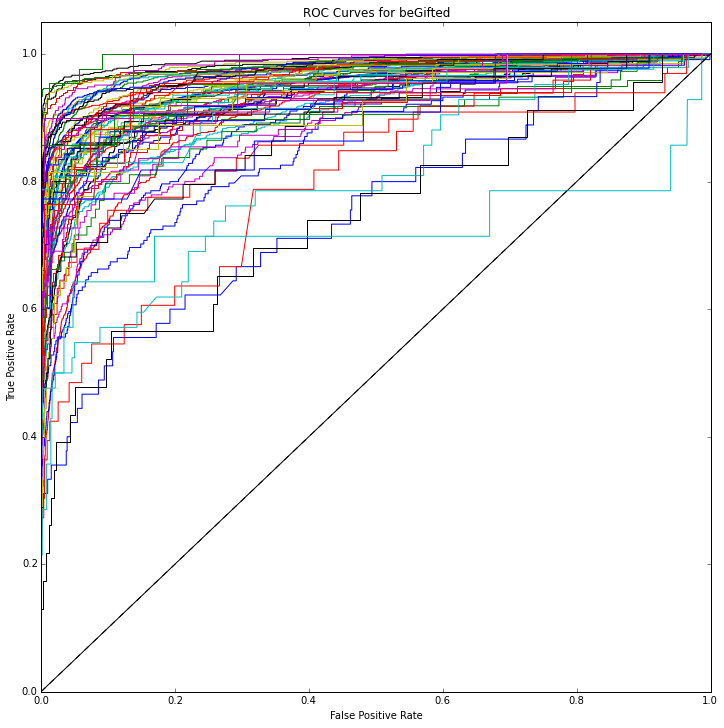

In [31]:
# Plot ROC curves for the multiclass problem

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(12, 12))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for beGifted')
#plt.legend(loc="lower right")
plt.savefig('../images/ROC_curves.jpg')
plt.show()


### WordClouds

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

def freq_to_text(dictionary):
    text = ''
    for v in dictionary.itervalues():
        text = text + ''.join([(word[0] + ' ') * int(word[1]* 100) for word in v])
    return text

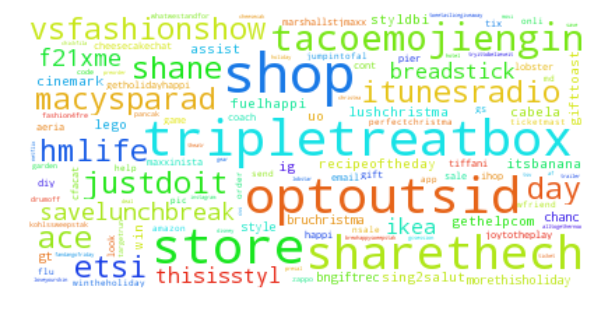

In [18]:
# word cloud for everything in company_tweets['stripped_text']

from os import path
from wordcloud import WordCloud

# Read the whole text.
text = freq_to_text(important_words)

# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(background_color="white", max_font_size=40, relative_scaling=.5).generate(text)
plt.figure(figsize=(10,10))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

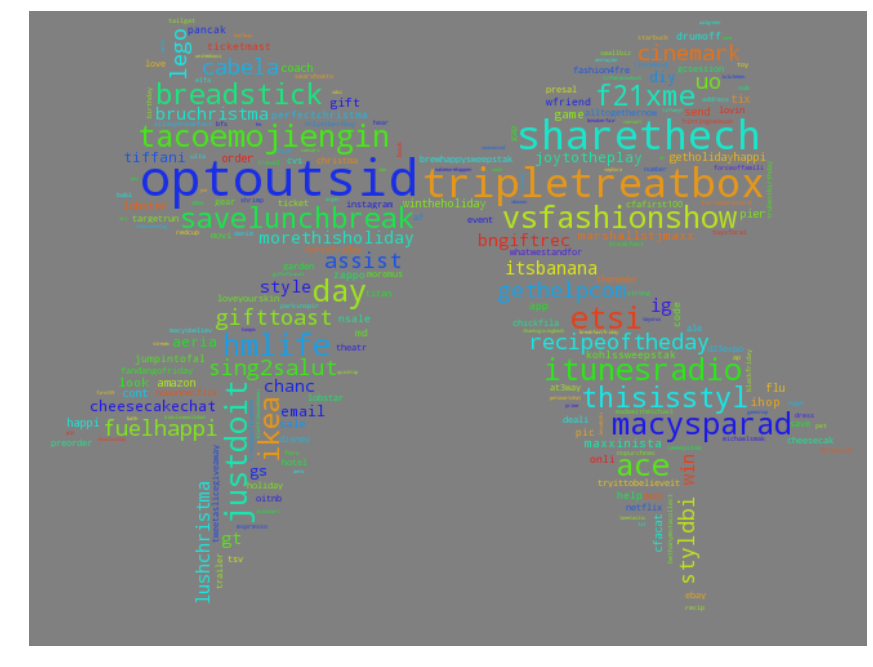

In [97]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

# Read the whole text.
text = freq_to_text(important_words)

# image taken from http://cliparts.co/cliparts/Aib/j86/Aibj865rT.png
ribbon_mask = np.array(Image.open('../images/ribbon_mask.png'))

t = set(['shop', 'new', 'shane', 'store'])
STOPWORDS.update(t)
wc = WordCloud(background_color="gray", max_words=2000, mask=ribbon_mask, stopwords=STOPWORDS, relative_scaling=.5,\
              max_font_size=40)
# wordcloud = WordCloud(max_font_size=40, relative_scaling=.5).generate(text)
# generate word cloud
wc.generate(text)

# store to file
wc.to_file('../images/ribbon.png')

# show
plt.figure(figsize=(15,20))
plt.imshow(wc)
plt.axis("off")
# plt.figure(figsize=(10,10))
# plt.imshow(present_mask, cmap=plt.cm.gray)
# plt.axis("off")
plt.show()

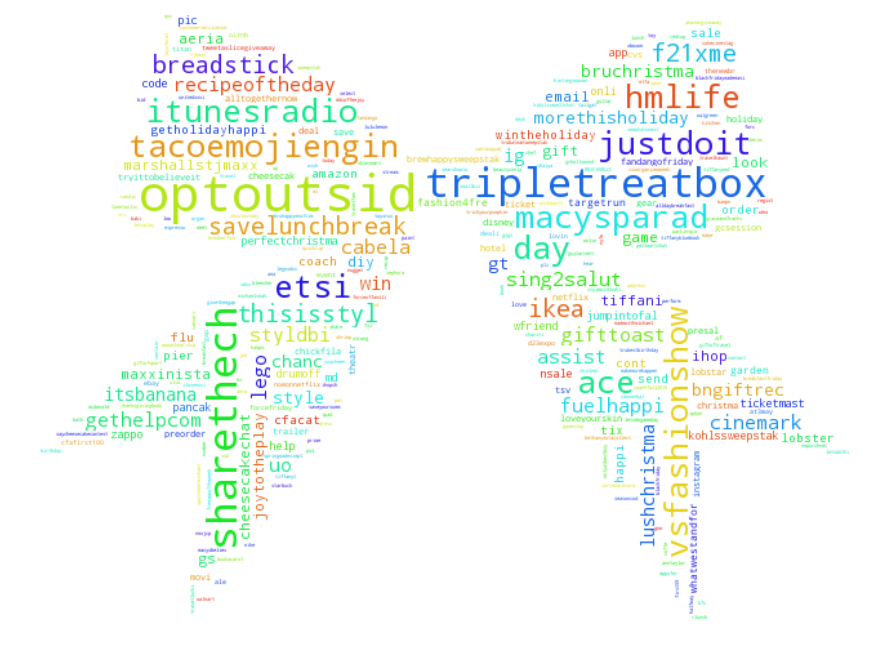

In [19]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

# image taken from http://cliparts.co/cliparts/Aib/j86/Aibj865rT.png
ribbon_mask = np.array(Image.open('../images/ribbon_mask.png'))

t = set(['shop', 'new', 'shane', 'store'])
STOPWORDS.update(t)
wc = WordCloud(background_color="white", max_words=2000, mask=ribbon_mask, stopwords=STOPWORDS, relative_scaling=.5,\
              max_font_size=40)
# wordcloud = WordCloud(max_font_size=40, relative_scaling=.5).generate(text)
# generate word cloud
wc.generate(text)

# store to file
wc.to_file('../images/ribbon_whitebg.png')

# show
plt.figure(figsize=(15,20))
plt.imshow(wc)
plt.axis("off")
# plt.figure(figsize=(10,10))
# plt.imshow(present_mask, cmap=plt.cm.gray)
# plt.axis("off")
plt.show()